# Summary of Results

We use a regression-based neural network for this problem. The results of the neural network vs. the surrogate are summarized in the table below.

| Run # | RMSE in surrogate | RMSE in NN | Avg. number of iterations |
|:-----:|:-----------------:|:----------:|:-------------------------:|
| 0     | 10.6              | 17.3       | 96.5                      |
| 1     | 12.6              | 18.7       | 105.7                     |
| 2     | 12.0              | 17.3       | 108.5                     |
| 3     | 9.2               | 23.7       | 104.5                     |

The details of the methodology with explanations of each step are included below.

# Using Artificial Neural Networks for Predicting Conjugate Gradient Iteration Times

Systems of partial differential equations can be solved numerically using the iterative conjugate gradient method. However, the number of iterations required to solve the system can vary wildly. The purpose of this project is to predict the number of iterations required to solve the system. We will be using data from an already existing prediction method, which contains four coefficients that paramaterize the system, the iteration count, and the method's iteration predictions. Then we will train an artificial neural network on these data points and compare our results with the already existing method.

## Processing Raw Files into CSV

The first step in approaching the problem is parsing the fenl_surr.out_8 file into a .csv which is easier to analyze and use.

In [1]:
import re

# Data Column numbers
NUM_COLS = 6
D1 = 0
D2 = 1
D3 = 2
D4 = 3
PRED = 4
RES = 5

# Initialize Arrays, counters, and files
data = []
grid_level = 0
num_points = 0
i_order = []
outfile = None
outdir = "surr_8_proc"
infile = "fenl_surr.out_8"
surrOutfile = open(outdir + "/surr_8_agg.csv", 'w')
surrOutfile.write("level,points,d1,d2,d3,d4,predicted,actual\n")

# Write lines of data to a file
def writeToFile():
    if outfile != None:
        for j, ls in enumerate(data):
            surrOutfile.write(format("%d,%d,"%(grid_level,num_points)))
            for k in ls[:-1]:
                outfile.write(format("%f,"%k))
                surrOutfile.write(format("%f,"%k))
            outfile.write(format("%f\n"%ls[-1]))
            surrOutfile.write(format("%f\n"%ls[-1]))
        outfile.close()

for i, line in enumerate(open('fenl_surr.out_8')):
    
    # Start of new Level
    if re.match("Tasmanian.+", line):
        writeToFile()
        grid_level += 1
        outfile = open(format("%s/surr_8_level_%d.csv")%
                      (outdir,grid_level), 'w')
        outfile.write("d1,d2,d3,d4,predicted,actual\n")
        data = []
        words = line.split(" ")
        num_points = int(words[4])
        continue
    
    # Parse predictions from the surrogate
    if re.match("Predicted.+", line):
        for word in re.findall("\S+", line)[4:]:
            vals = re.findall("[\d']+", word)
            data.append([0]*NUM_COLS)
            data[-1][PRED] = int(vals[1])
        continue
    
    # Parse data line
    if re.match("\d+ :", line):
        
        i_order = []
        for word in re.findall("\(\d+,\d+\)", line):
            vals = re.findall("[\d]+", word)
            index = int(vals[0])
            i_order.append(index)
            res = int(vals[1])
            data[index][RES] = res
        
        index = 0
        for word in re.findall("\[ [-\.\d ]+]", line):
            vals = re.findall("\S+", word)
            for j, val in enumerate(vals[1:-1]):
                data[i_order[j]][index] = float(val)
            index += 1
writeToFile()
surrOutfile.close()
print("Done")

Done


## Cross-validation

Now that the data is in an easy-to-read format, we shuffle the data points and split them evenly across four different files. This way, the neural net can be trained on groups of three files at a time, and then validated on the fourth file.

In [4]:
import numpy as np

np.random.seed(4) # set the random seed for reproducable results

outdir = "regression_data"

# Load in our csv
data = np.loadtxt("surr_8_proc/surr_8_agg.csv",
                  delimiter=',',
                  skiprows=1,
                  usecols=[2,3,4,5,6,7])

# Shuffle the data points
np.random.shuffle(data)

# Define split sizes
num_splits = 4
validation_size = int(np.ceil(data.shape[0]//num_splits))

# Split the data evenly into sets of training data and validation data
for i in range(num_splits):
    starti = validation_size*i
    endi = validation_size*(i+1)
    trainfile = open(format("%s/training%02d.csv"%(outdir,i)), 'w')
    testfile = open(format("%s/validation%02d.csv"%(outdir,i)), 'w')
    trainfile.write("d1,d2,d3,d4,iters,surr_pred\n")
    testfile.write("d1,d2,d3,d4,iters,surr_pred\n")
    for j in range(0,int(validation_size*i)):
        for k, datum in enumerate(data[j]):
            trainfile.write(format("%f"%datum))
            if k < data.shape[1] - 1:
                trainfile.write(",")
        trainfile.write("\n")
    for j in range(int(validation_size*i),int(validation_size*(i+1))):
        for k, datum in enumerate(data[j]):
            testfile.write(format("%f"%datum))
            if k < data.shape[1] - 1:
                testfile.write(",")
        testfile.write("\n")
    for j in range(int(validation_size*(i+1)),data.shape[0]):
        for k, datum in enumerate(data[j]):
            trainfile.write(format("%f"%datum))
            if k < data.shape[1] - 1:
                trainfile.write(",")
        trainfile.write("\n")
    trainfile.close()
    testfile.close()
print("Done")

Done


## Creating and Training the Neural Network

Now all that is left to do is create, train, and validate our neural networks. We will be using Keras to create our neural networks.

In [8]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

# Initialize rmse arrays
surrRMSE = []
modelRMSE = []
histories = []

for i in range(num_splits):
    
    # Load in the training data and validation data for the split
    print("Training split %d of %d"%(i, num_splits))
    dataset = np.loadtxt(format("%s/training%02d.csv"%(outdir,i)),
                         delimiter=',',
                         skiprows=1)
    validation = np.loadtxt(format("%s/validation%02d.csv"%(outdir,i)),
                         delimiter=',',
                         skiprows=1)
    
    # Load the training data
    X = dataset[:,0:4]
    Y = dataset[:,4:5]
    
    # Load the validation data
    xval = validation[:,0:4]
    yval = validation[:,4:5]
    
    # Create a 5-layer neural network with 4 input nodes,
    # 3 rows of 100 hidden nodes, and 1 output node
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    
    # Train the neural network and store the results
    history = model.fit(X, Y,
                    epochs=200,
                    batch_size=10,
                    verbose=0,
                    validation_data=(xval,yval))
    histories.append(history)
    modelRMSE.append(history.history['val_loss'][-1]**.5)
    surrRMSE.append(np.mean((validation[:,4] - validation[:,5])**2)**.5)
print("Done")

Training split 0 of 4
Training split 1 of 4
Training split 2 of 4
Training split 3 of 4
Done


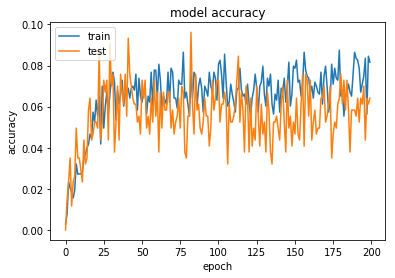

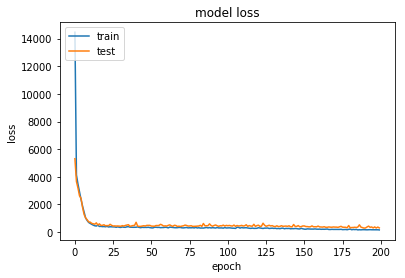

    Model validation rmse: 17.298838
Surrogate validation rmse: 10.606808
-----------------------------------------------------------



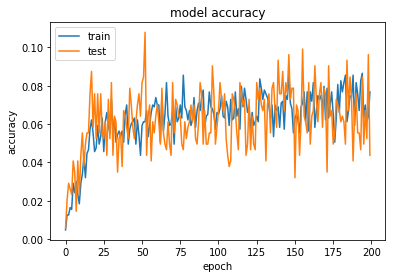

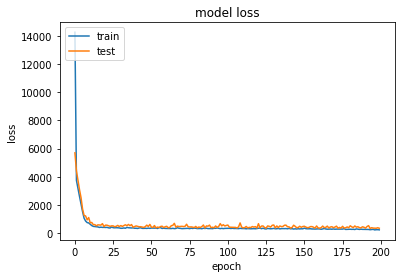

    Model validation rmse: 18.671553
Surrogate validation rmse: 12.645999
-----------------------------------------------------------



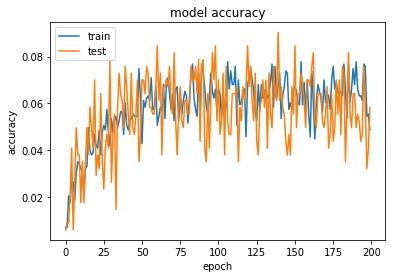

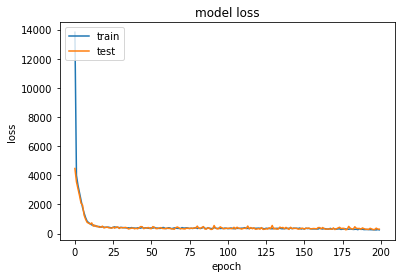

    Model validation rmse: 17.271119
Surrogate validation rmse: 11.974828
-----------------------------------------------------------



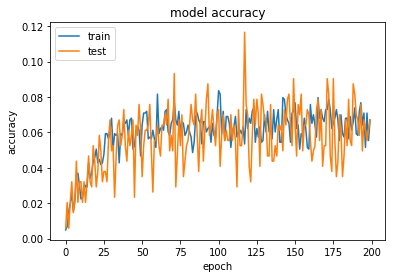

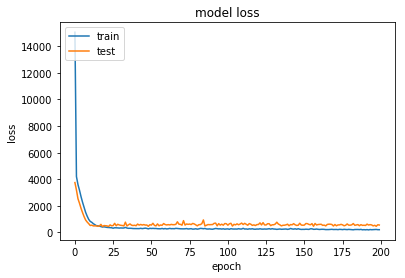

    Model validation rmse: 23.689017
Surrogate validation rmse: 9.238183
-----------------------------------------------------------



In [9]:
# Display the results of each split
for i, history in enumerate(histories):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    print("    Model validation rmse: %f"%modelRMSE[i])
    print("Surrogate validation rmse: %f"%surrRMSE[i])
    print("-----------------------------------------------------------\n")